# APMTH 207: Advanced Scientific Computing: 
## Stochastic Methods for Data Analysis, Inference and Optimization
## Group Project -- Final Deliverables
**Harvard University**<br>
**Fall 2018**<br>
**Instructors: Rahul Dave**<br>

**Paper Name: Distilling the Knowledge in a Neural Network**<br>
**Paper URL: https://arxiv.org/abs/1503.02531**

**Team name: ENSEMBLE**<br>
**Team members:**<br>
-- Timothy Lee (lee709@g.harvard.edu)

-- Shiyun Qiu (shiyunqiu@g.harvard.edu)

-- Xiangru Shu (xiangru_shu@g.harvard.edu)

-- Yuyue Wang (yuyue_wang@g.harvard.edu)

---

## Background Information

For large-scale machine learning tasks, such as speech and object recognition, a cumbersome model is commonly used to acheive high accuracy. The cumbersome model could be an ensemble of smaller models or a single large model trained with a strong regularizer. However, it is impractical to deploy the cumbersome model to a large number of users due to limited computational resources. One solution to this problem is to transfer the knowledge from the cumbersome model to a small model more suitable for deployment through "distillation".

When we are distilling the knowledge of a cumbersome model into a small model, we should train the small model to generalize in the same way as the cumbersome model so that the small model can generalize well to new data. One way to transfer the generalization ability is to use the class probabilities produced by the cumbersome model as "soft targets" when training the small model. When the large model is an ensemble of simpler models, we can take an arithmetic or geometric mean of the predictive distributions as the soft targets. As these soft targets contain probabilities of all incorrect classes in addition to the probability of the correct class, we can obtain a lot of information about how the large model generalizes from the relative probabilites in each training case. Soft targets with high entropy have much less variance in the gradient between training cases, so we can train the small model with less data and a higher learning rate.

---

## Summary of Methods

### Distillation

#### Class Probability
For neural networks, the class probabilities, $q_i$ are usually computed through the softmax output layer,
$$ q_i = \frac{\exp\{z_i/T\}}{\Sigma_j\exp\{z_j/T\}},$$
where $z_i$'s are the logits, i.e. the vector of raw (non-normalized) predictions that a classification model generates, and T is a temperature which is normally set to 1. Higher temperature leads to similar class probabilities (similar $q_i$ values), so it produces a softer probability distribution over classes. 

#### Simplest Form of Distillation 
The distilled model will be trained on a transfer set. Each training case in the transfer set is a soft target distribution produced by the cumbersome model with a high temperature in its softmax. We will use the same high temperature to train the distilled model. After the model is trained, we will use a temperature of 1 to predict.

#### Correct Labels Partially Known for the Transfer Set
Two objective functions are needed.

Objective function 1: cross entropy with the soft targets.<br>
We need to use the same high temperature used to train the cumbersome model in the softmax of the distilled model. 

Objective function 2: cross entropy with the correct labels.<br>
We need to use the same logits in softmax of the distilled model but at a temperature of 1.

$$ \mathcal{L}(x; W) = \alpha * \mathcal{H}(\sigma(z_c/\tau), \sigma(z_d/\tau)) + \beta * \mathcal{H}(y, \sigma(z_d)), $$
where x is the input, W is the model parameters in the distilled model, $\mathcal{H}$ is the cross entropy function, $\sigma$ is the softmax function, $\tau$ is the temperature used to train the cumbersome model, $z_c$ is the logit of the cumbersome model, $z_d$ is the logit of the distilled model, and $\alpha$ and $\beta$ are the weights ($\beta=1-\alpha$).

A weighted average of these two objective functions will be computed with a considerably lower weight placed on the second one (i.e. significantly smaller $\beta$). 

The magnitudes of the graidents of soft targets scale as $1/T^2$. To prevent the relative contributions of the hard and soft targets from changing when we adjust meta-parameters, we will multiply both of them by $T^2$.


### Digit Matching as Special Case of Distillation

Previous work by Caruana and his collaborators used logits produced by the softmax as the targets for training the small model by minimizing the squared difference between the logits produced by the cumbersome model and those produced by the small model. In this section, we will show that matching the logits is indeed a special case of distillation.

The cross-entropy with the soft targets for each class $i$ can be computed as the following,
$$ 
\begin{align}
\mathcal{H}(\sigma(z_{ci}/\tau), \sigma(z_{di}/\tau)) 
&= - \frac{\exp\{z_{ci}/\tau\}}{\Sigma_j\exp\{z_{cj}/\tau\}} * \log (\frac{\exp\{z_{di}/\tau\}}{\Sigma_j\exp\{z_{dj}/\tau\}})\\
&= - \frac{\exp\{z_{ci}/\tau\}}{\Sigma_j\exp\{z_{cj}/\tau\}} * (z_{di}/\tau - 
\log (\Sigma_j\exp\{z_{dj}/\tau\})).\\
\end{align}
$$

Taking gradient of the cross-entropy with respect to $z_{di}$ gives us,
$$
\begin{align}
\frac{\partial \mathcal{H}(\sigma(z_{ci}/\tau), \sigma(z_{di}/\tau))}{\partial z_{di}}
&= \frac{1}{\tau}(\frac{\exp\{z_{di}/\tau\}}{\Sigma_j\exp\{z_{dj}/\tau\}} - \frac{\exp\{z_{ci}/\tau\}}{\Sigma_j\exp\{z_{cj}/\tau\}}).
\end{align}
$$

When the temperature $\tau$ is high compared with the magnitude of the logits, we can approximate $\exp\{z_{i}/\tau\}$ through taylor expansion, i.e. $\exp\{z_{i}/\tau\} \approx 1+z_{i}/\tau$. So the gradient can be estimated as following,
$$
\begin{align}
\frac{\partial \mathcal{H}(\sigma(z_{ci}/\tau), \sigma(z_{di}/\tau))}{\partial z_{di}}
&\approx \frac{1}{\tau}(\frac{1+z_{di}/\tau}{N+\Sigma_j z_{dj}/\tau} - \frac{1+z_{ci}/\tau}{N+\Sigma_j z_{cj}/\tau}),
\end{align}
$$
where N is the number of total classes.

When the logits are zero-meaned for each transfer case, i.e. $\Sigma_j z_{dj} = \Sigma_j z_{cj} = 0$, the gradient can be simplified to 
$$
\begin{align}
\frac{\partial \mathcal{H}(\sigma(z_{ci}/\tau), \sigma(z_{di}/\tau))}{\partial z_{di}}
&\approx \frac{1}{\tau}(\frac{1+z_{di}/\tau}{N} - \frac{1+z_{ci}/\tau}{N})\\
&\approx \frac{1}{N\tau^2}(z_{di} - z_{ci}).\\
\end{align}
$$

So when the temperature is high, distillation is also minimizing $\frac{1}{2}(z_{di} - z_{ci})$, the squared difference between the logits produced by the cumbersome model and those produced by the small model.

---

## Python Reimplementation

### MNIST

### CIFAR-10

#### Generalist Model

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
%matplotlib inline

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Files already downloaded and verified
Files already downloaded and verified


 frog horse truck  bird


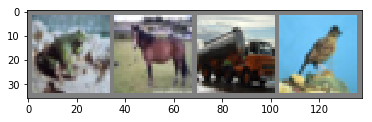

In [3]:



# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [4]:



class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
#         x = F.softmax(x, dim)
        return x

    
    
generalist_net = Net()

In [5]:


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(generalist_net.parameters(), lr=0.001, momentum=0.9)

In [6]:
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = generalist_net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.208
[1,  4000] loss: 1.898
[1,  6000] loss: 1.709
[1,  8000] loss: 1.594
[1, 10000] loss: 1.547
[1, 12000] loss: 1.483
[2,  2000] loss: 1.436
[2,  4000] loss: 1.391
[2,  6000] loss: 1.343
[2,  8000] loss: 1.334
[2, 10000] loss: 1.300
[2, 12000] loss: 1.305
[3,  2000] loss: 1.230
[3,  4000] loss: 1.209
[3,  6000] loss: 1.212
[3,  8000] loss: 1.217
[3, 10000] loss: 1.185
[3, 12000] loss: 1.216
[4,  2000] loss: 1.126
[4,  4000] loss: 1.126
[4,  6000] loss: 1.106
[4,  8000] loss: 1.132
[4, 10000] loss: 1.109
[4, 12000] loss: 1.110
[5,  2000] loss: 1.028
[5,  4000] loss: 1.043
[5,  6000] loss: 1.051
[5,  8000] loss: 1.059
[5, 10000] loss: 1.045
[5, 12000] loss: 1.047
Finished Training


GroundTruth:    cat  ship  ship plane


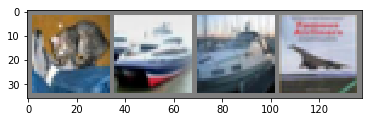

In [7]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [8]:
outputs = generalist_net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat   car  ship plane


In [9]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = generalist_net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 59 %


In [11]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = generalist_net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 70 %
Accuracy of   car : 81 %
Accuracy of  bird : 33 %
Accuracy of   cat : 49 %
Accuracy of  deer : 51 %
Accuracy of   dog : 43 %
Accuracy of  frog : 70 %
Accuracy of horse : 60 %
Accuracy of  ship : 68 %
Accuracy of truck : 67 %


In [ ]:
# nb_classes = 10

# confusion_matrix_train = torch.zeros(nb_classes, nb_classes)
# with torch.no_grad():
#     for i, (inputs, classes) in enumerate(trainloader):
#         inputs = inputs.to(device)
#         classes = classes.to(device)
#         outputs = net(inputs)
#         _, preds = torch.max(outputs, 1)
#         for t, p in zip(classes.view(-1), preds.view(-1)):
#                 confusion_matrix_train[t.long(), p.long()] += 1

# print(confusion_matrix_train)


In [ ]:
# confusion_matrix_test = torch.zeros(nb_classes, nb_classes)
# with torch.no_grad():
#     for i, (inputs, classes) in enumerate(testloader):
#         inputs = inputs.to(device)
#         classes = classes.to(device)
#         outputs = net(inputs)
#         _, preds = torch.max(outputs, 1)
#         for t, p in zip(classes.view(-1), preds.view(-1)):
#                 confusion_matrix_test[t.long(), p.long()] += 1

# print(confusion_matrix_test)

#### Specialist 1: Animal Specialist

In [12]:
# Generate specialist training dataset
# (Half from specialist group, Half Dustbin)
animals = [2, 3, 4, 5, 6, 7]
transportation = [0, 1, 8, 9]


animals_train = []
trans_train = []


special_animal_train = []
special_trans_train = []

animal_counters = [0,0,0,0,0,0]

special_counts = 20000
special_animal_each = special_counts/len(animals)
special_trans_each = special_counts/len(transportation)

for data in trainset:
    image, label = data
    if label in animals:
        animals_train.append(data)
        animal_idx = animals.index(label)
        if animal_counters[animal_idx] < special_animal_each:
            special_animal_train.append((image, animals.index(label)))
            animal_counters[animal_idx] += 1
    else:
        trans_train.append(data)
        special_trans_train.append((image, transportation.index(label)))

In [13]:
print(len(special_animal_train),len(special_trans_train))
# print(animal_counters)

20004 20000


In [43]:
import copy
trans_dustbin_indices =  np.random.choice(len(animals_train),special_counts,replace=False)
trans_dustbin = [animals_train[i] for i in trans_dustbin_indices]
animals_dustbin = copy.deepcopy(trans_train)

# relabel all dustbin data 
animals_dustbin = [(data[0],6) for data in animals_dustbin]
trans_dustbin = [(data[0],4) for data in trans_dustbin]

In [44]:
print('length of animal specialist train:',len(special_animal_train))
print('length of animal specialist dustbin',len(animals_dustbin))
print()
print('length of trans specialist train:',len(special_trans_train))
print('length of trans specialist dustbin',len(trans_dustbin))



length of animal specialist train: 20004
length of animal specialist dustbin 20000

length of trans specialist train: 20000
length of trans specialist dustbin 20000


In [45]:
animal_specialist_trainset = special_animal_train + animals_dustbin
trans_specialist_trainset = special_trans_train + trans_dustbin
print(len(animal_specialist_trainset),len(trans_specialist_trainset))

40004 40000


In [46]:
animal_loader = torch.utils.data.DataLoader(animal_specialist_trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

trans_loader = torch.utils.data.DataLoader(trans_specialist_trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

In [47]:
class animalNet(nn.Module):
    def __init__(self):
        super(animalNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 7)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    
animal_net = animalNet()

In [48]:
animal_net

animalNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=7, bias=True)
)

In [49]:
# Initialize weights with weights of generalist model

animal_net.conv1.weight.data = generalist_net.conv1.weight
animal_net.conv2.weight.data = generalist_net.conv2.weight
animal_net.fc1.weight.data = generalist_net.fc1.weight
animal_net.fc2.weight.data = generalist_net.fc2.weight
# animal_net.fc3.weight.data = generalist_net.fc3.weight


In [50]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(animal_net.parameters(), lr=0.001, momentum=0.9)

In [51]:
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(animal_loader, 0):
        # get the inputs
        inputs, labels = data
        
#         print(inputs, labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = animal_net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 0.637
[1,  4000] loss: 0.557
[1,  6000] loss: 0.542
[1,  8000] loss: 0.544
[1, 10000] loss: 0.558
[2,  2000] loss: 0.468
[2,  4000] loss: 0.506
[2,  6000] loss: 0.510
[2,  8000] loss: 0.521
[2, 10000] loss: 0.538
[3,  2000] loss: 0.452
[3,  4000] loss: 0.460
[3,  6000] loss: 0.492
[3,  8000] loss: 0.477
[3, 10000] loss: 0.496
[4,  2000] loss: 0.437
[4,  4000] loss: 0.434
[4,  6000] loss: 0.448
[4,  8000] loss: 0.466
[4, 10000] loss: 0.488
[5,  2000] loss: 0.356
[5,  4000] loss: 0.425
[5,  6000] loss: 0.440
[5,  8000] loss: 0.473
[5, 10000] loss: 0.461
Finished Training


GroundTruth:  tensor(1) tensor(6) tensor(6) tensor(6)
Predicted:  tensor(1) tensor(6) tensor(6) tensor(6)
Accuracy of the network on the 10000 test images: 86 %


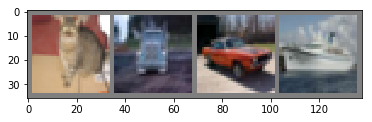

In [52]:
dataiter = iter(animal_loader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % labels[j] for j in range(4)))

outputs = animal_net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % predicted[j]
                              for j in range(4)))

correct = 0
total = 0
with torch.no_grad():
    for data in animal_loader:
        images, labels = data
        outputs = animal_net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

### specialist 2: transportation



In [53]:
class transNet(nn.Module):
    def __init__(self):
        super(transNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    
trans_net = transNet()

In [54]:
# Initialize weights with weights of generalist model

trans_net.conv1.weight.data = generalist_net.conv1.weight
trans_net.conv2.weight.data = generalist_net.conv2.weight
trans_net.fc1.weight.data = generalist_net.fc1.weight
trans_net.fc2.weight.data = generalist_net.fc2.weight


In [55]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(trans_net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for i, data in enumerate(trans_loader, 0):
        # get the inputs
        inputs, labels = data
        for label in labels:
            if label > 4:
                print(labels)

In [56]:
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trans_loader, 0):
        # get the inputs
        inputs, labels = data
        
#         print(inputs, labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = trans_net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 0.628
[1,  4000] loss: 0.508
[1,  6000] loss: 0.506
[1,  8000] loss: 0.497
[1, 10000] loss: 0.478
[2,  2000] loss: 0.409
[2,  4000] loss: 0.423
[2,  6000] loss: 0.423
[2,  8000] loss: 0.428
[2, 10000] loss: 0.422
[3,  2000] loss: 0.360
[3,  4000] loss: 0.364
[3,  6000] loss: 0.383
[3,  8000] loss: 0.383
[3, 10000] loss: 0.373
[4,  2000] loss: 0.308
[4,  4000] loss: 0.346
[4,  6000] loss: 0.346
[4,  8000] loss: 0.349
[4, 10000] loss: 0.347
[5,  2000] loss: 0.286
[5,  4000] loss: 0.309
[5,  6000] loss: 0.309
[5,  8000] loss: 0.317
[5, 10000] loss: 0.344
Finished Training


GroundTruth:  tensor(2) tensor(0) tensor(4) tensor(3)
Predicted:  tensor(2) tensor(2) tensor(4) tensor(3)


Exception ignored in: <function _DataLoaderIter.__del__ at 0x11feb07b8>
Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
  File "/anaconda3/lib/python3.7/site-packages/torch/multiprocessing/reductions.py", line 167, in rebuild_storage_filename
    storage = cls._new_shared_filename(manager, handle, size)
RuntimeError: Interrupted system call at /Users/soumith/miniconda2/conda-bld/pytorch_1532624435833/work/torch/lib/libshm/core.cpp:99


Accuracy of the network on the 10000 test images: 90 %


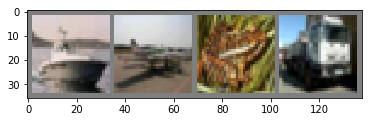

In [60]:
dataiter = iter(trans_loader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % labels[j] for j in range(4)))

outputs = trans_net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % predicted[j]
                              for j in range(4)))

correct = 0
total = 0
with torch.no_grad():
    for data in trans_loader:
        images, labels = data
        outputs = trans_net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

#### Inference / Test

In [61]:
# implement inference step 1& 2 (Paper section 5.4)

## Analysis and Comparison